<a href="https://colab.research.google.com/github/eportah/Bird-of-Prey-Identifier/blob/main/adjustToPEP8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup dataset

#mount the drive to retrieve dataset
from google.colab import drive
drive.mount('/content/drive')

#import ZipFile to read dataset
from zipfile import ZipFile

#establish paths
ZIP_PATH = "/content/drive/MyDrive/MachineLearning/Datasets/birdsDatasets.zip"
EXTRACT_PATH = "/content/EXTRACT_PATH"

#extract and open dataset in read mode using ZipFile
with ZipFile(ZIP_PATH, 'r') as zip_obj:
   zip_obj.extractall(EXTRACT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#load dataset

#cell output rundown
"""
- Dataset has 300 files (images) split into 2 classes.
- Class names are 'birdsOfPrey' and 'notBirdsOfPrey'.
- Images are batched into groups of 32, resized 224x224 pixels, 3 color RGB.
- Labels stored in 1-D array of length 32, one label per image in the batch.
"""

#store dataset path import tensorflow to load images from directory
DATASET_DIR = "/content/EXTRACT_PATH/birdsDataset"
import tensorflow as tf

#load dataset and establish both image size and batch size
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR, image_size=(224,224), batch_size=32
  )

#preview what got loaded and what dataset looks like
class_names = train_dataset.class_names
print("Class names:", class_names)
for images, labels in train_dataset.take(1):
  print("Image batch shape:", images.shape)
  print("Label batch shape:", labels.shape)

Found 300 files belonging to 2 classes.
Class names: ['birdsOfPrey', 'notBirdsOfPrey']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [3]:
#split dataset

#cell output rundown
"""
- 210, 70% for training
- 90, 30% for validation
- Batch sizes are the same for both training and validation
"""

#load training dataset, 70% of data
training_dataset = tf.keras.utils.image_dataset_from_directory(
   DATASET_DIR,
   validation_split=0.3,
   subset="training",
   seed=123,
   image_size=(224,224),
   batch_size=32
)

#load validation dataset, 30% of data
validation_dataset = tf.keras.utils.image_dataset_from_directory(
   DATASET_DIR,
   validation_split=0.3,
   subset="validation",
   seed=123,
   image_size=(224,224),
   batch_size=32
)

#preview one batch from training dataset
print("Training batch shapes:")
for images_train, labels_train in training_dataset.take(1):
  print("Images:", images_train.shape)
  print("Labels:", labels_train.shape)

#preview one batch from validation dataset
print("Validation batch shapes:")
for images_val, labels_val in validation_dataset.take(1):
 print("Images:", images_val.shape)
 print("Labels:", labels_val.shape)

Found 300 files belonging to 2 classes.
Using 210 files for training.
Found 300 files belonging to 2 classes.
Using 90 files for validation.
Training batch shapes:
Images: (32, 224, 224, 3)
Labels: (32,)
Validation batch shapes:
Images: (32, 224, 224, 3)
Labels: (32,)


In [4]:
#preprocess dataset

#import MobileNetV2 preprocessing
from keras.applications.mobilenet_v2 import preprocess_input

#define data_augmentation
data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomFlip("horizontal"),
   tf.keras.layers.RandomRotation(0.1),
   tf.keras.layers.RandomZoom(0.1)
])

#apply augmentation and MobileNetV2 preprocessing with map to transform batches
train_set = training_dataset.map(
    lambda x, y: (preprocess_input(data_augmentation(x)),y)
  )

#apply MobileNetV2 preprocessing to validation
valid_set = validation_dataset.map(lambda x, y: (preprocess_input(x),y))

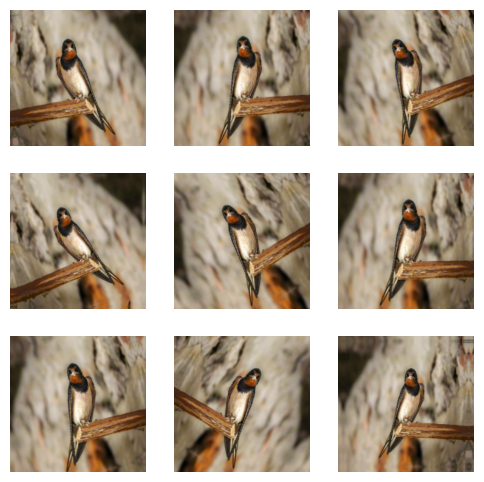

In [5]:
#preview augmentation

#import pyplot to visualize tensors as images and numpy for numpy indexing
import matplotlib.pyplot as plt
import numpy as np

#take one raw image from unmapped training dataset and select first image
for imgs, labs in training_dataset.take(1):
  batch_images = imgs.numpy()
  batch_labels = labs.numpy()
sample_image = batch_images[0]
sample_label = batch_labels[0]

#establish grid and create a figure for plotting
augmented_num = 9
plt.figure(figsize = (6,6))

#add batch dimension and apply augmentation
for i in range(augmented_num):
  img_batch = np.expand_dims(sample_image, axis = 0)
  img_augmented = data_augmentation(img_batch)[0].numpy()

  #clip to ensure values within range and cast to convert to 8-bit unsigned int
  img_augmented = np.clip(img_augmented, 0, 255).astype("uint8")

  #finish off by plotting each augmented image in a 3x3 grid
  axes = plt.subplot(3,3, i+1)
  axes.imshow(img_augmented)
  axes.axis('off')

In [6]:
#build model

#import MobileNetV2 to use as base
from keras.applications import MobileNetV2
from keras import layers, models

#load base MobiletNetV2 and drop original classifier
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

#freeze base so pretrained weights are not trained right away
base_model.trainable = False

#add custom classifier head by using layers
"""
Rectified linear unit relu to prevent exploding values
Softmax turn output into prob's, has chances an image could belong to a class
Dense layer to learn how much each feature matters for classying species
GAP2D squeeze feature maps into single vector instead of tensor flattening
Dropout to randomly turn off 30% neurons during training to prevent overfitting
"""
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [7]:
#compile model

#import optimizers to use Adam
from keras import optimizers

#.compile for optimizer, loss, metrics
"""
Set learning rate to 0.0001 to avoid ruining pretrained weights
Sparse categorical crossentropy since classes are labeled as integers
Accuracy metric to track model performance
"""
model.compile(
    optimizer = optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
#train model

#cell output rundown
"""
Training data divided into batches of images (batch size=32)
7 batches per epoch
Model updates its weights after each batch
Over epochs, accuracy increases and loss decreases
Validation accuracy starts high due to pretrained MobileNetV2 base
"""

#set 15 epochs to get started and change depending on how it fits
EPOCHS = 15

#fit the model with training history
"""
history stores loss and accuracy curves to be plotted later
"""
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=EPOCHS
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.0296 - loss: 2.6532 - val_accuracy: 0.3778 - val_loss: 1.5104
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5096 - loss: 1.3092 - val_accuracy: 0.7333 - val_loss: 0.8924
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7212 - loss: 0.9149 - val_accuracy: 0.7444 - val_loss: 0.6414
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7754 - loss: 0.6347 - val_accuracy: 0.7889 - val_loss: 0.5007
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7969 - loss: 0.5117 - val_accuracy: 0.8444 - val_loss: 0.4187
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8636 - loss: 0.3945 - val_accuracy: 0.8667 - val_loss: 0.3712
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8672 - loss: 0.3957 - val_accuracy: 0.8333 - val_loss: 0.3442
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8788 - loss: 0.3162 - val_accuracy: 0.8556 - val_loss: 0.3293
Epoch 9/15

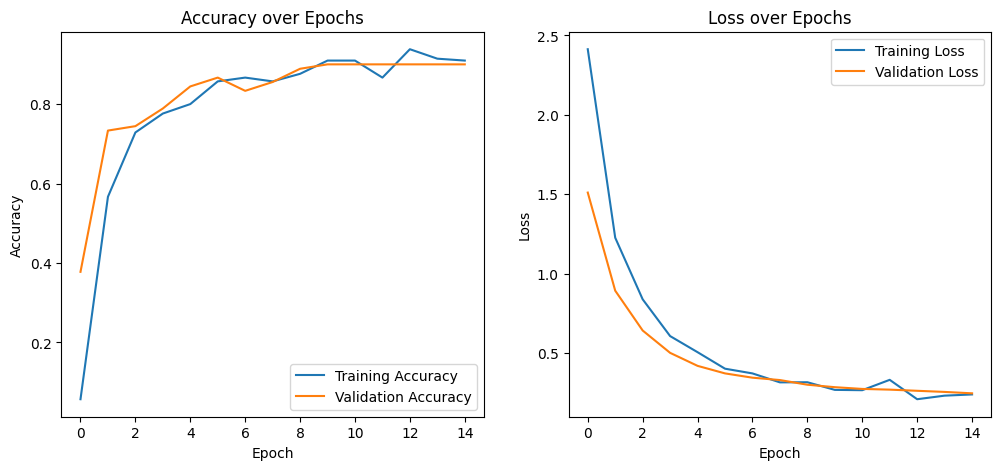

In [9]:
#evaluate curves

#extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#number of epochs
epochs_range = range(len(acc))

#plot accuracy and loss
plt.figure(figsize=(12, 5))

#accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


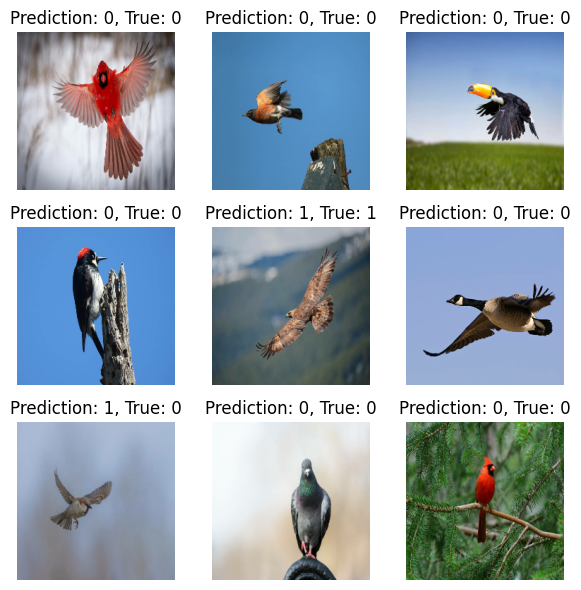

In [10]:
#inspect predictions

#cell output rundown
"""
3x3 grid of 9 birds
Prediction compared with ground truth
If correctly predicted, values (1 or 0) align
birdsOfPrey, 1
notBirdsOfPrey, 0
"""

#take batch from validation set
"""
.predict to get probabilities
.argmax to get predicted class
axis=1 to look across columns for each row
actual (true) labels is ground truth
"""
for images, labels in valid_set.take(1):
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  actual_labels = labels.numpy()
  images_batch = images.numpy()

#flip labels so that birdsOfPrey = 1
predicted_labels = 1 - predicted_labels
actual_labels = 1- actual_labels

#plot first 9 images in batch with prediction vs ground truth
"""
Show first 9 images in batch for simplicity
(images_batch[i]+1)/2 to convert from [-1,1] to [0,1]
Fstring to format labels
True for ground truth
.axis off to hide unwanted ticks and labels
"""
plt.figure(figsize=(6,6))
for i in range(9):
  axes = plt.subplot(3, 3, i+1)
  plt.imshow((images_batch[i]+1)/2)
  plt.title(f"Prediction: {predicted_labels[i]}, True: {actual_labels[i]}")
  plt.axis('off')

#tight layout so nothing overlaps
plt.tight_layout()
plt.show()

In [11]:
#save model

#save to birdOfPreyIdentifier.keras
"""
.save to save completed model into permanent file
.keras as the file extension to save architecture, weights, optimization state
File saved to temporary storage of Colab session
Saved permanently by downloading to desktop and uploading to mounted drive
"""
model.save('bird_of_prey_identifier.keras')

#print statement to show save was succesful
print("Model saved to bird_of_prey_identifier.keras")

Model saved to bird_of_prey_identifier.keras


In [12]:
#load model

#cell output rundown
"""
Layers
MobileNetV2 (base) extracts general image features
Custom layers take features from base and learn how to use them for bird images

Output Shape
'None' for for training large batches and predictions on individual items
Last shape so model outputs 6 prob scores for each img, 1 for each of the 6

Parameters
Individual dials the model adjusts during training to learn
Param of 0 since they perform a fixed math operation without learning anything
Trainable params are what was specifically tuned in project for bird dataset
Non-train params are frozen dials from pre-trained MobileNetV2 base borrowed
Optimizer params are internal var Adam uses for training process
Adam keeps track of past avg gradients and past avg of the square of its grads
"""

#import tf to make cell self-contained and avoid running extra cells
import tensorflow as tf

#establish path
model_path = (
  '/content/drive/MyDrive/MachineLearning/Models/bird_of_prey_identifier.keras'
 )

#load trained model
loaded_model = tf.keras.models.load_model(model_path)

#print model summary to show load was succesful and with additional model info
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,752,212 (10.50 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,486 (1.26 MB)

In [13]:
#predict unseen data

#prep for image preprocessing
import numpy as np
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input

#define class names used during training and define prediction function
"""
Load image from file path while resize to match input size model was trained on
Convert image to np array for model to work with nums rather than image files
Not using np.asarray() as it will be in uint8 rather than float32
Modify shape by adding extra dimension to turn single image into batch of one
Set axis=0 to insert new dimension at the very front of original shape
Preprocess image by applying same scaling used during training
Get model's prediction to feed prepped image to model and output array of probs
"""
class_names = ['birdsOfPrey', 'notBirdsOfPrey']
def predict_bird_of_prey(image_path, model):

  img = image.load_img(image_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  img_preprocess = preprocess_input(img_batch)
  prediction = model.predict(img_preprocess)

  #establish prediction's human readibility and return for later use
  """
  Uses np.argmax to find index of highest probability
  Uses predicted index to look up the name in list
  Uses np.max to get highest prob and convert to percent for confidence score
  Confidence score probability that model assigns to its prediction for an img
  """
  index_predicted = np.argmax(prediction[0])
  class_predicted = class_names[index_predicted]
  confidence = np.max(prediction[0]) * 100
  return class_predicted, confidence

#test function and use it to make prediction and print results with f-string
test_image_path = (
    '/content/extractPath/birdsDataset/birdsOfPrey/eagle/eagleFlight1.jpg'
    )
class_predicted, confidence = predict_bird_of_prey(
    test_image_path, loaded_model
    )

print(f"Prediction: {class_predicted}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
Prediction: birdsOfPrey
Confidence: 99.55%


In [14]:
#install StreamLit by getting library

!pip install streamlit

In [15]:
#create app file

#import needed libraries and save cell content to new file
%%writefile bird_of_prey_app.py
import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input

#set up page
st.set_page_config(page_title="Bird Of Prey Identifier")
st.title("Bird of Prey Identifier")
st.write(
  "Upload image of a bird for the model to predict")

#establish path
MODEL_PATH = 'birdOfPreyIdentifier.keras'

#cache command to load model once rather than each time an image is uploaded
@st.cache.resource
def loadTrainedModel():
  model = tf.keras.models.load_model(MODEL_PATH)
  return model

#define class names
CLASS_NAMES = ['eagle', 'falcon', 'hawk', 'owl', 'vulture', 'NotBirdsOfPrey']

#preprocess image and return predicted class and confidence score
"""
convert image to numpy array
add extra dimension for batch
preprocess image for model
get model's prediction and turn into human-readable result
get specific bird type
"""
def predict_bird_of_prey(img_to_predict, model):
  img = img_to_predict.convert('RGB')
  img = img.resize((224, 224))
  img_array = image.img_to_array(img)

  img_batch = np.expand_dims(img_array, axis=0)

  img_preprocessed = preprocess_input(img_batch)

  prediction = model.predict(img_preprocessed)
  predicted_index = np.argmax(prediction[0])
  specific_bird = CLASS_NAMES[predicted_index]
  confidence = np.max(prediction[0]) * 100

  if specific_bird == 'notBirdOfPrey':
    result_spec_bird = "Not a bird of prey"
  else:
    result_spec_bird = f"Bird of Prey ({specific_bird.capitalize()})"

  return result_spec_bird, confidence

#load model and create file uploader
model = load_trained_model()
uploaded_file = st.file_uploader(
    "Upload an image...", type=["jpg", "jpeg", "png"]
    )

#classify uploaded image and yield prediction and confidence
"""
st.image to open file as an image
st.button to create Classify button
st.spinner for a loading message
st.success and st.info for results
"""
if uploaded_file is not None:
  pil_image = Image.open(uploaded_file)
  st.image(pil_image, caption='Uploaded image', use_column_width=True)
  if st.button('Classify'):
    with st.spinner('Classifying...'):
      predicted_class, confidence = predict_bird_of_prey(pil_image, model)
      st.success(f"Prediction: **{predicted_class}**")
      st.info(f"Confidence: **{confidence:.2f}%**")

Overwriting bird_of_prey_app.py


In [16]:
#deployment requirements

%%writefile requirements.txt
streamlit
tensorflow
Pillow
numpy

Overwriting requirements.txt
